In [39]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [40]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [41]:
train_dir =  "D:/Python/tensorflow/data/ncc/train" #"D:/Python/tensorflow/data/Image Classification/seg_train/seg_train"#
test_dir =  "D:/Python/tensorflow/data/ncc/test" #"D:/Python/tensorflow/data/Image Classification/seg_test/seg_test"

classes = os.listdir(train_dir)
print(classes, len(classes))

['beam_bottom', 'wall_panel'] 2


In [42]:
N = []
for i in range(len(classes)):
    N+=[i]

mapping = dict(zip(classes, N))
reverse_mapping = dict(zip(N, classes))

def mapper(value):
    return reverse_mapping[value ]    

In [43]:
dataset, count = [], 0
for file in tqdm(os.listdir(train_dir)):
    path = os.path.join(train_dir, file)
    for im in os.listdir(path):
        image = load_img(os.path.join(path, im), grayscale=False, color_mode = "rgb", target_size = (100,100))
        image = img_to_array(image)
        image = image/255.0
        dataset.append([image, count])
    count += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.62it/s]


In [44]:
testset, count = [], 0
for file in tqdm(os.listdir(test_dir)):
    path = os.path.join(test_dir, file)
    for im in os.listdir(path):
        image = load_img(os.path.join(path, im), grayscale=False, color_mode = "rgb", target_size = (100,100))
        image = img_to_array(image)
        image = image/255.0
        testset.append([image, count])
    count += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]


In [45]:
data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

In [46]:
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

In [47]:
tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

In [48]:
data2 = data.reshape(-1, 100, 100, 3)
test2 = test.reshape(-1, 100, 100, 3)

In [49]:
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)

In [50]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(17, 100, 100, 3)
(5, 100, 100, 3)
(17, 2)
(5, 2)


In [51]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range = 20, zoom_range=0.2,width_shift_range=0.2, height_shift_range=0.2, shear_range= 0.1, fill_mode="nearest")  

In [52]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(100,100,3), include_top = False, weights="imagenet", pooling="avg")
pretrained_model3.trainable = False

In [53]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation="relu")(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(6, activation="softmax")(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [54]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 106, 106, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [61]:
model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']) # loss="categorical_crossentropy"

In [63]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=8),validation_data=(testx,testy),epochs=15)

Epoch 1/15


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [8,6] and labels shape [16]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\adity\AppData\Local\Temp/ipykernel_22508/3437180187.py:1) ]] [Op:__inference_train_function_127187]

Function call stack:
train_function


In [70]:
#model.save("D:/Python/tensorflow/data/ncc") # model will be named as saved_model.pb by default

INFO:tensorflow:Assets written to: D:/Python/tensorflow\assets


In [71]:
new_model = tf.keras.models.load_model('D:/Python/tensorflow/data/ncc') # It will automatically read the saved_model.pb file by default.
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [72]:
y_pred=new_model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       429
           1       0.97      0.98      0.98       455
           2       0.81      0.81      0.81       483
           3       0.82      0.82      0.82       524
           4       0.92      0.89      0.90       462
           5       0.91      0.85      0.88       454

    accuracy                           0.88      2807
   macro avg       0.88      0.88      0.88      2807
weighted avg       0.88      0.88      0.88      2807



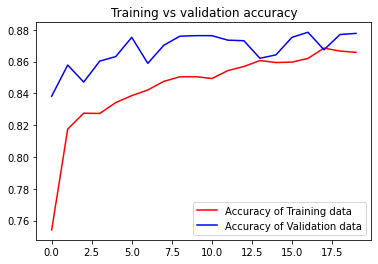

<Figure size 432x288 with 0 Axes>

In [73]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

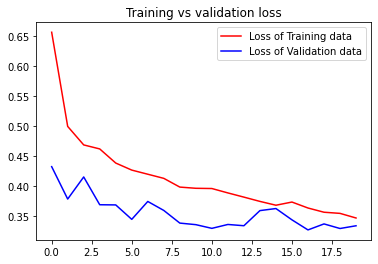

<Figure size 432x288 with 0 Axes>

In [74]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

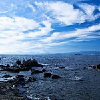

In [76]:
load_img("D:/Python/tensorflow/data/Image Classification/seg_test/seg_test/sea/20316.jpg",target_size=(100,100))

In [79]:
image=load_img("D:/Python/tensorflow/data/Image Classification/seg_test/seg_test/sea/20167.jpg",target_size=(100,100))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [80]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
#print(prediction)
#print(value)
print("Prediction is {}.".format(move_name))

Prediction is sea.


In [81]:
print(test.shape)
prediction2=model.predict(test)
print(prediction2.shape)

PRED=[]
for item in prediction2:
    value2=np.argmax(item)      
    PRED+=[value2]

(3000, 100, 100, 3)
(3000, 6)


In [82]:
ANS=tlabels0

In [83]:
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.882
